In [1]:
import os
def count_images(folder_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')
    return sum(1 for file in os.listdir(folder_path) if file.lower().endswith(image_extensions))

# Set your folder path
folder_path = '/Users/bakuljangley/Documents/Research Assignment/VPRMethods/sanity_check/'
image_count = count_images(folder_path)
print(f'Total images: {image_count}')

Total images: 33


In [2]:
#51.989920, 4.344672

import os
import csv
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

def convert_to_decimal(degree_tuple):
    degrees, minutes, seconds = degree_tuple
    return degrees + (minutes / 60.0) + (seconds / 3600.0)

def get_gps_data(exif_data):
    gps_info = exif_data.get("GPSInfo")
    if not gps_info:
        return None, None, None
    
    lat = lon = yaw = None
    
    lat_ref = gps_info.get(1)
    lat_data = gps_info.get(2)
    if lat_ref and lat_data:
        lat = convert_to_decimal(lat_data)
        if lat_ref != 'N':
            lat = -lat

    lon_ref = gps_info.get(3)
    lon_data = gps_info.get(4)
    if lon_ref and lon_data:
        lon = convert_to_decimal(lon_data)
        if lon_ref != 'E':
            lon = -lon
    
    yaw = gps_info.get(17) or gps_info.get(24)
    return lat, lon, yaw

def extract_exif_to_csv(folder_path, csv_path):
    # Define common image extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.tiff', '.webp')

    # Define CSV headers
    fieldnames = ['id', 'image_name', 'captured_at', 'sequence', 'lat', 'long', 'orientation']
    
    # Open CSV file for writing
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        # Loop through images and collect EXIF data
        for i, image_name in enumerate(os.listdir(folder_path), start=0):
            if image_name.lower().endswith(image_extensions):
                image_path = os.path.join(folder_path, image_name)
                
                with Image.open(image_path) as img:
                    exif_data = img._getexif()
                    if exif_data:
                        # Convert EXIF tag IDs to names
                        exif = {TAGS.get(tag_id, tag_id): value for tag_id, value in exif_data.items()}
                        
                        # Extract required EXIF info
                        lat, lon, yaw = get_gps_data(exif)
                        captured_at = exif.get("DateTimeOriginal")  # Date and time captured

                        # Write the row to CSV
                        writer.writerow({
                            'id': i,
                            'image_name': image_name,
                            'captured_at': captured_at,
                            'sequence': 'custom',  # Replace with sequence value if available
                            'lat': lat,
                            'long': lon,
                            'orientation': yaw
                        })
                    else:
                        print(f"No EXIF data for {image_name}")

# Set the folder path and CSV output path
csv_path = 'metadata.csv'
extract_exif_to_csv(folder_path, csv_path)


Map saved as map.html



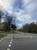
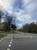
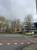
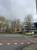
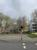
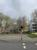
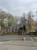
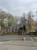
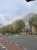
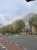
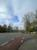
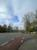
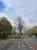
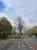
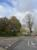
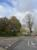
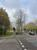
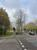
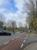
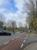
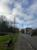
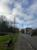
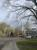
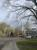
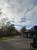
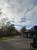
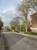
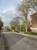
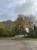
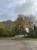
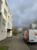
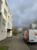
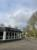
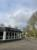
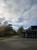
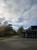
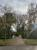
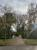
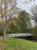
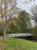
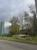
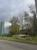
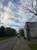
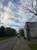
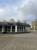
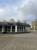
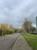
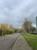
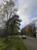
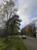
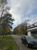
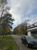
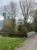
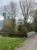
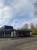
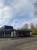
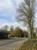
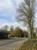
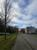
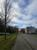
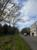
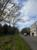
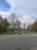
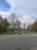
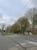
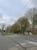

In [7]:
import folium
from folium.plugins import MarkerCluster
from PIL import Image
import base64
import pandas as pd
import io
from io import BytesIO

def get_image_html(img_path, width=50):
    # Load and resize the image
    with Image.open(img_path) as img:
        img = img.rotate(-90, expand=True)
        img.thumbnail((width, width))
        # Convert the image to base64
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return f'<img src="data:image/jpeg;base64,{img_str}" width="{width}" height="{width}">'

def plot_images_on_map(csv_path, image_folder, output_map='map.html'):
    # Load data from CSV
    data = pd.read_csv(csv_path)
    
    # Initialize the map centered on average coordinates
    avg_lat = data['lat'].mean()
    avg_lon = data['long'].mean()
    folium_map = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

    # Initialize a marker cluster
    # marker_cluster = MarkerCluster().add_to(folium_map)
    pin_locations=[]


    # Add the custom pins to the map
    for location in pin_locations:
        folium.Marker(
            location=location,
            popup=f'{location}',  # You can customize this popup if needed
            icon=folium.Icon(color='blue')  # Change the icon color as desired
        ).add_to(folium_map)

        
    # Loop through each image data entry
    for _, row in data.iterrows():
        # Get the file path for the image
        image_path = os.path.join(image_folder, f"{row['image_name']}")
        lat, lon = row['lat'], row['long']
        image_id = row['id']
        image_name = row['image_name']
        orientation = row['orientation']
        # Create the HTML for the image
        image_html = get_image_html(image_path)

        icon_html = f"""
        <div style="
            position: relative;
            width: 30px;
            height: 30px;
            border-radius: 50%;
            text-align: center;
            line-height: 30px;
        ">
            <div style="
                transform: rotate({orientation}deg);
                position: absolute;
                top: 50%;
                left: 50%;
                transform-origin: center;
                font-size: 16px;
                font-weight: bold;
            ">
                &#x21E7;  <!-- Bold arrow -->
            </div>
        </div>
        """
        # Add blue marker
        folium.Marker(
            location=[lat, lon],
            popup=f"{image_html}<br>ImageIndex: {image_id}, Name: {image_name}, Orientation: {orientation}",
            tooltip=f"ImageIndex: {image_id}, Orientation: {orientation}",
            icon=folium.Icon(color='blue')
        ).add_to(folium_map)
        # Add marker with the rotating arrow and color intensity
        folium.Marker(
            location=[lat, lon],
            popup=f"{image_html}<br>ImageIndex: {image_id}, Name: {image_name},Orientation: {orientation}",
            tooltip=f"ImageIndex: {image_id}, Orientation: {orientation}",
            icon=folium.DivIcon(html=icon_html)
        ).add_to(folium_map)

    # Save the map to an HTML file
    folium_map.save(output_map)
    print(f"Map saved as {output_map}")
    display(folium_map)




# Plot images on the map
plot_images_on_map(csv_path, folder_path)


In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, Image



df = pd.read_csv(csv_path)

# Function to display image and metadata
def display_image(index):
    row = df.iloc[index]
    img_path = os.path.join(folder_path, row['image_name'])
    
    # Display image
    display(Image(filename=img_path, width=400))
    
    # Display metadata
    metadata = f"""
    <b>Image Name:</b> {row['image_name']}<br>
    <b>Captured At:</b> {row['captured_at']}<br>
    <b>Latitude:</b> {row['lat']}<br>
    <b>Longitude:</b> {row['long']}<br>
    <b>Orientation:</b> {row['orientation']}°
    """
    display(HTML(metadata))

# Create a slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(df) - 1,
    step=1,
    description='Image Index:',
    continuous_update=False
)

# Create an output widget to display the image and metadata
out = widgets.Output()

# Function to update display when slider changes
def on_value_change(change):
    with out:
        out.clear_output(wait=True)
        display_image(change['new'])

# Connect the slider to the update function
slider.observe(on_value_change, names='value')

# Display the slider and output
display(slider, out)

# Initial display
with out:
    display_image(0)

IntSlider(value=0, continuous_update=False, description='Image Index:', max=32)

Output()